In [1]:
%cd ..
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from melp import Detector
import melp
import math
import random

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt
import melp.clustering.three_frame_cluster as clump_3

plt.rcParams.update({'font.size': 16})

/home/erik/GitHub/melp
Welcome to JupyROOT 6.24/06


In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
#filename_sorted_big = "/home/erik/GitLab_KIP/melp/root_files/big_run_data/sorted1.root"
#filename_sorted_big = "./testdata/sorted/sorted1_big.root"
#fix
filename_sorted_big = "./testdata/sorted/root_files_fixed/mu3e_sorted_000127.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")
ttree_sensor = file.Get("alignment/sensors")
ttree_tiles = file.Get("alignment/tiles")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

file_big = ROOT.TFile(filename_sorted_big)
ttree_mu3e_big = file_big.Get("mu3e")
ttree_mu3e_mc_big = file_big.Get("mu3e_mchits")
ttree_sensor_big = file_big.Get("alignment/sensors")
ttree_tiles_big = file_big.Get("alignment/tiles")

In [3]:
mu3e_detector = Detector.initFromROOT(filename_sorted)

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [4]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=Loaded Tiles: 5824, SensorModules=<melp.src.sensor.SensorModule object at 0x7fa86b1f8b80>))


In [5]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [6]:
#select frame to analyze
frame_used = 343 #29 #182
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#set time threshold 
time_threshold_used = 1.2 #ns

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks, __ = clump.masks.build_mask_around_cluster_master(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])


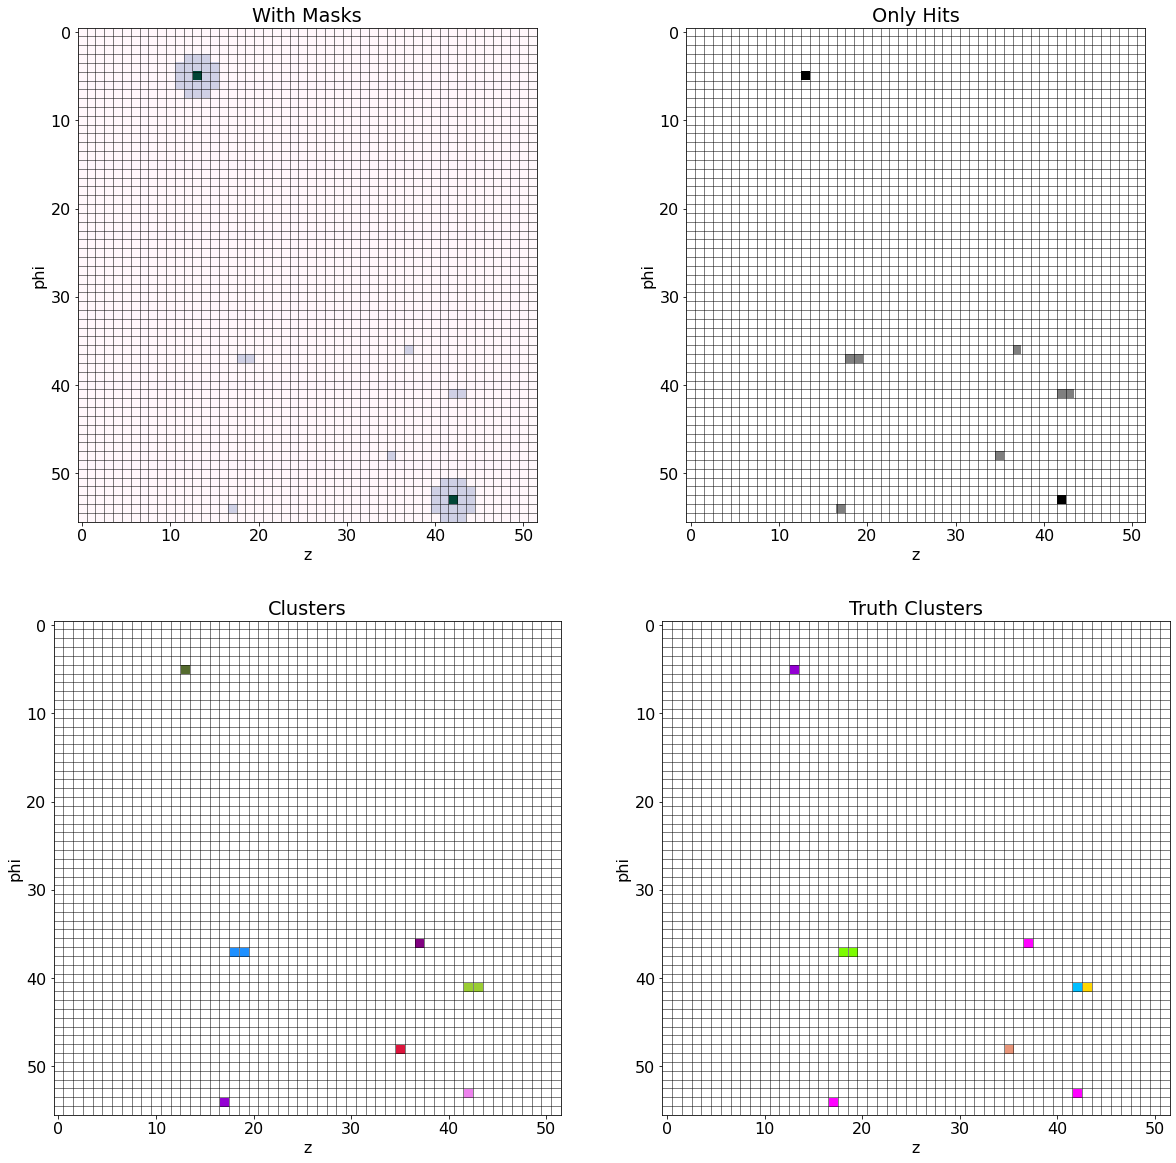

In [7]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")

#plot clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = clump.three_dim_cluster.spatial_clustering_for_time_clusters(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, time_threshold_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""
                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#cluster_numbers = []
#for x in range(np.shape(cluster_grid)[0]):
#    for y in range(np.shape(cluster_grid)[1]):
#        if cluster_grid[x][y] != 0:
#            cluster_numbers.append(cluster_grid[x][y])
#print(np.sort(cluster_numbers))   

#plot reference truth clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters_truth = clump.spatial_cluster.build_truth_cluster(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters_truth)):
    cluster_masters.append(clusters_truth[i].master_id)
    whole_clusters.append(clusters_truth[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Truth Clusters")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

In [8]:
clusters = clump.three_dim_cluster.spatial_clustering_for_time_clusters(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)
#print(clusters)

In [9]:
hit_counter = 0 
for cluster in clusters:
    hit_counter += cluster.__len__()
print(hit_counter)

22


In [10]:
time_clusters = clump.time_cluster.time_clustering_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)
#print(time_clusters)

In [11]:
time_hit_counter = 0
for time_cluster in time_clusters:
    time_hit_counter += time_cluster.__len__()
print(time_hit_counter)

22


In [12]:
print(len(time_clusters))

9


## Efficiency plots

In [13]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timethenspatial")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  1000
Total #hits in frames/#hits in clusters =  1.0
Correctly associated out of all hits:  42.95016278487353 %
Correctly associated out of all hits in clusters:  42.95016278487353 %
Incorrectly associated out of all hits:  57.04983721512647 %
Incorrectly associated out of all hits in clusters:  57.04983721512647 %


### Hits not included in any cluster

In [14]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timethenspatial")

Progress: 100 % of  1000  frameses
Not associated hits out of all hits:  0.0 %


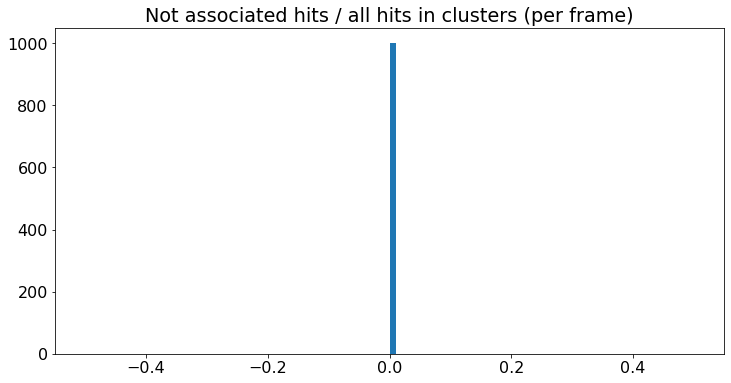

In [15]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

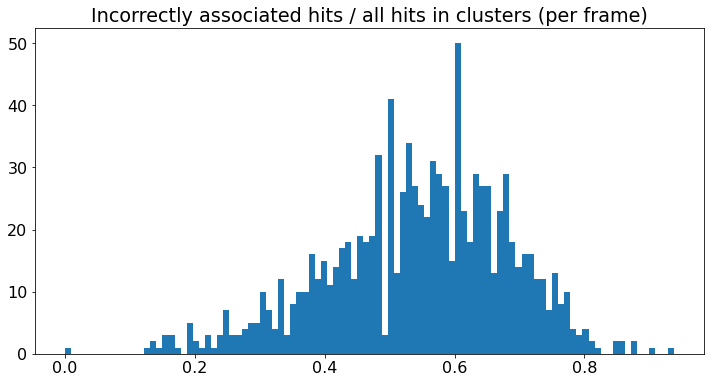

In [16]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

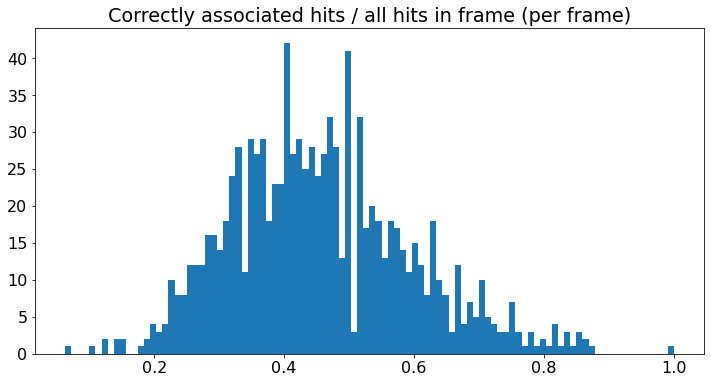

In [17]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

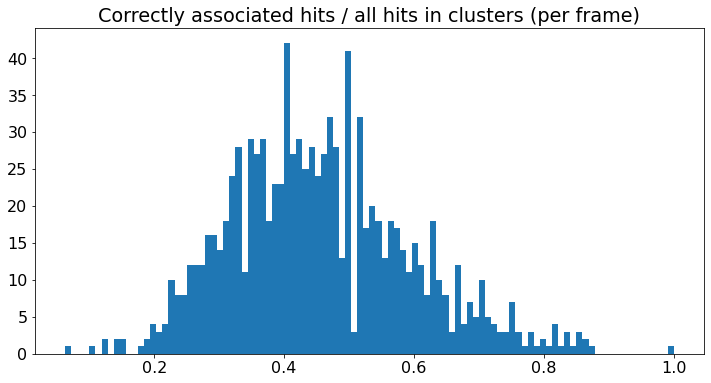

In [18]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

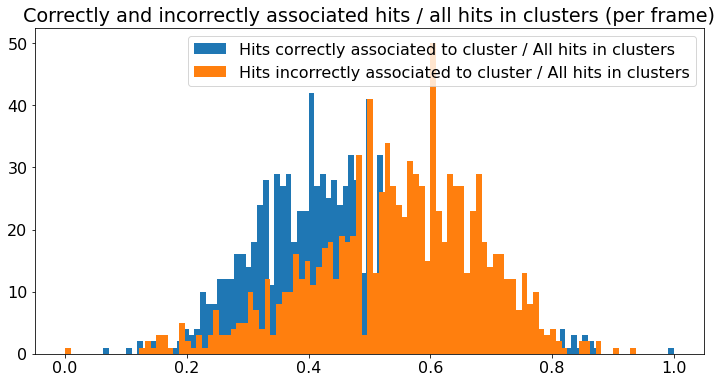

In [19]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()

# Time then iterative spatial masks

#Clusters: 14
#Truth clusters: 13
Tids [257891, 257891, 257891]
Times [27040.255944525055, 27039.098224838777, 27038.598320613743]
Primaries [257891, 257891, 257891]
Edeps [0.7994825653380873, 0.8281748826569557, 0.9102635252113586]


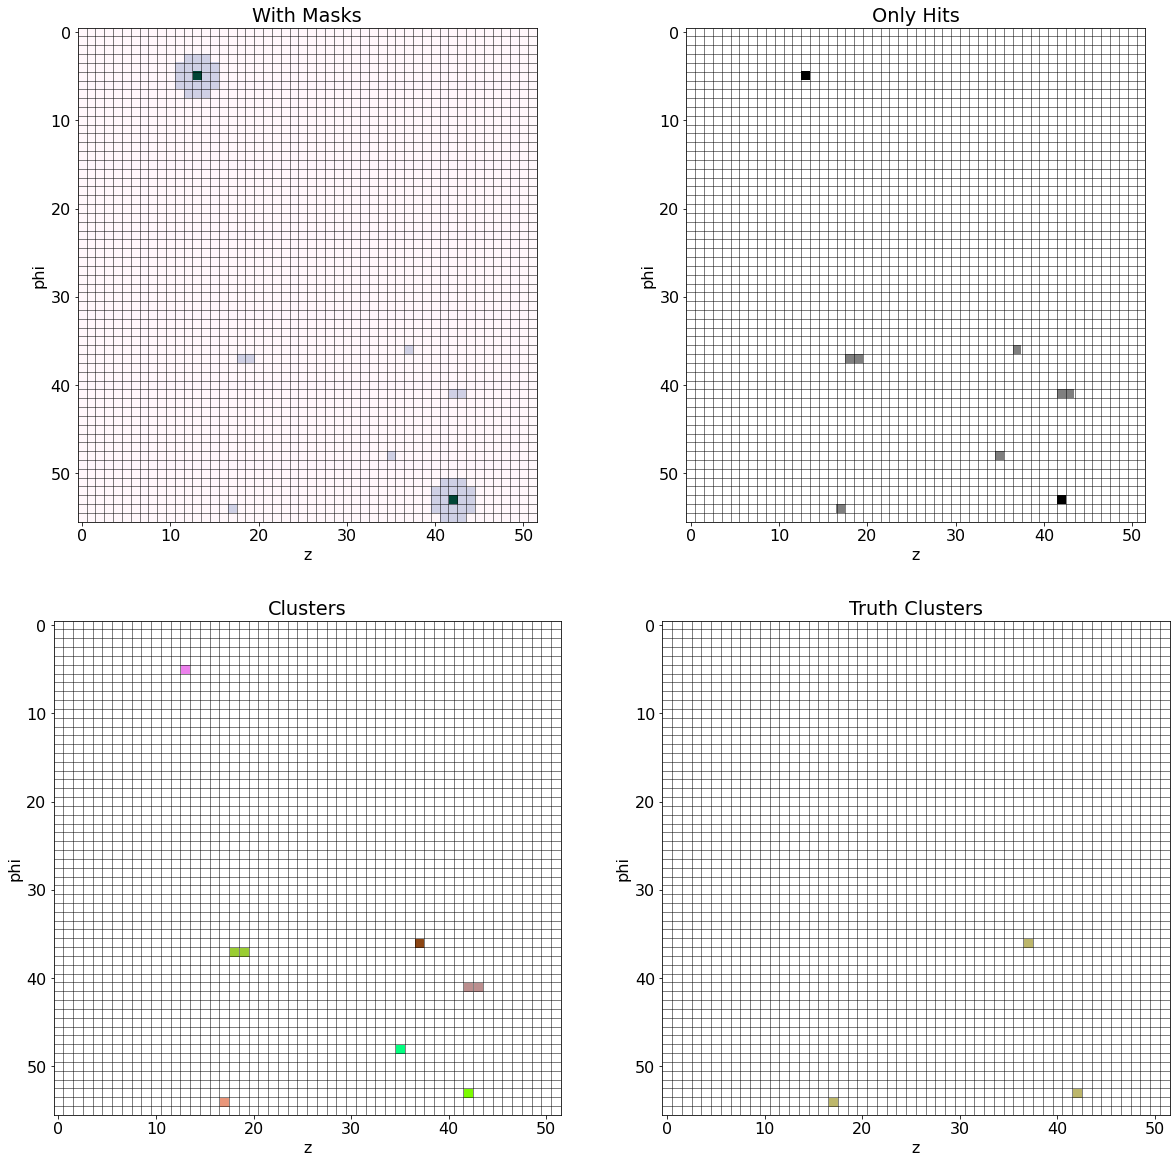

In [20]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")

#plot clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)
print("#Clusters:",len(clusters))
colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

#scatter biggest cluster
"""
cluster_len = []
keys_biggest = []
for key in clusters.keys():
    cluster_len.append(len(clusters[key]))
    keys_biggest.append(key)
index_biggest_cluster = np.where(cluster_len == np.max(cluster_len))[0][0]
biggest_cluster = clusters[keys_biggest[index_biggest_cluster]]
for tile2 in biggest_cluster:
    tile_det = mu3e_detector.TileDetector.tile[tile2[0]] 
    if tile2[0] < 300000:
        y = tile_det.row()
        x = tile_det.column()
        ax[1,0].scatter(x, y, color = "b", marker = "o", s = 32)
"""
                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()

#plot reference truth clusters
cluster_grid = np.zeros((52,56))
#clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big", rec_type = "pixelpixel")
clusters_0 = clump.spatial_cluster.build_truth_cluster(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, mask_type = "big", rec_type = None)
print("#Truth clusters:",len(clusters_0))
clusters = [clusters_0[5]] #[clusters_0[5]] #[clusters_0[1],clusters_0[2]]
##################
for cluster in clusters:
    print("Tids", cluster.get_tids())
    print("Times", cluster.get_times())
    print("Primaries", cluster.get_primaries())
    print("Edeps", cluster.get_edeps())
    #print(abs(cluster.get_times()[0]-cluster.get_times()[1]))
##################

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())
    
for i in range(len(whole_clusters)):
    for j in whole_clusters[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Truth Clusters")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

#fig.savefig("Inefficiency_Cases.png", dpi=300)

### Plot clusters in next three frames

8283

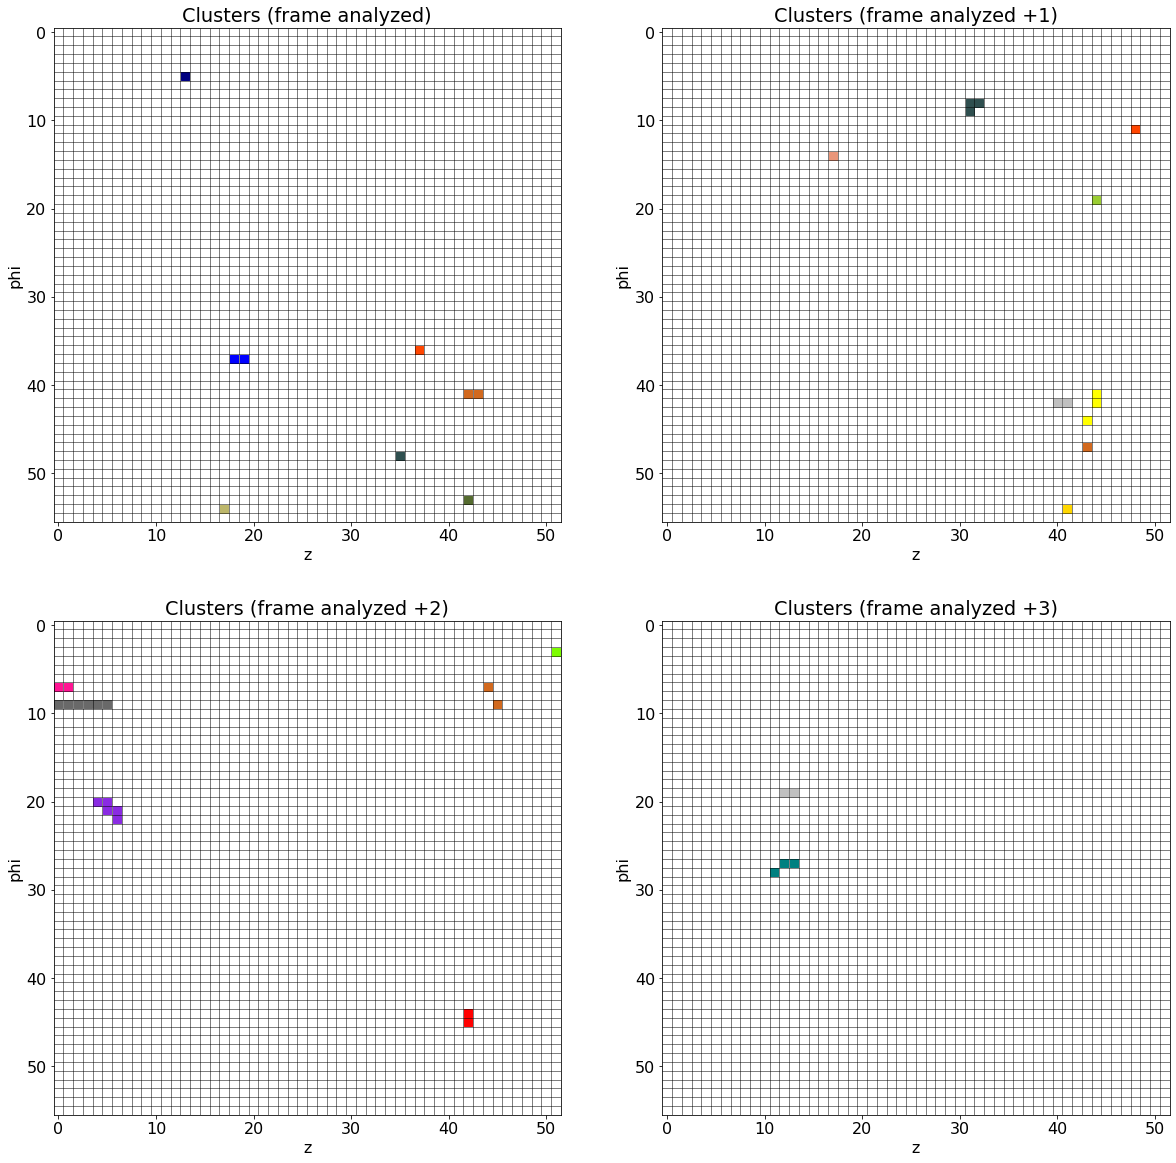

In [21]:
ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

#plot clusters
fig, ax = plt.subplots(2,2, figsize=(20,20))

#plot clusters in frame_analyzed
clusters1 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters_1 = []
whole_clusters_1 = []
for i in range(len(clusters1)):
    cluster_masters_1.append(clusters1[i].master_id)
    whole_clusters_1.append(clusters1[i].get_tile_ids())
    
for i in range(len(whole_clusters_1)):
    for j in whole_clusters_1[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("Clusters (frame analyzed)")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")
ax[0,0].set_xlim(-0.5,51.5)
ax[0,0].set_ylim(-0.5,55.5)
ax[0,0].invert_yaxis()

#plot clusters in frame_analyzed +1
ttree_mu3e.GetEntry(frame_used+1)
ttree_mu3e_big.GetEntry(frame_used+1)
clusters2 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame = frame_used+1, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters2 = []
whole_clusters2 = []
for i in range(len(clusters2)):
    cluster_masters2.append(clusters2[i].master_id)
    whole_clusters2.append(clusters2[i].get_tile_ids())
    
for i in range(len(whole_clusters2)):
    for j in whole_clusters2[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[0,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Clusters (frame analyzed +1)")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")
ax[0,1].set_xlim(-0.5,51.5)
ax[0,1].set_ylim(-0.5,55.5)
ax[0,1].invert_yaxis()


#plot clusters in frame_analyzed +2
ttree_mu3e.GetEntry(frame_used+2)
ttree_mu3e_big.GetEntry(frame_used+2)
clusters3 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used+2, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters3 = []
whole_clusters3 = []
for i in range(len(clusters3)):
    cluster_masters3.append(clusters3[i].master_id)
    whole_clusters3.append(clusters3[i].get_tile_ids())
    
for i in range(len(whole_clusters3)):
    for j in whole_clusters3[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,0].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters (frame analyzed +2)")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
ax[1,0].set_xlim(-0.5,51.5)
ax[1,0].set_ylim(-0.5,55.5)
ax[1,0].invert_yaxis()


#plot clusters in frame_analyzed +3
ttree_mu3e.GetEntry(frame_used+3)
ttree_mu3e_big.GetEntry(frame_used+3)
clusters4 = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used+3, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)

colors_arr = ["dimgrey", "silver", "rosybrown", "lightcoral", "brown", "darkred", "red", "darksalmon", "orangered", 
             "chocolate", "saddlebrown", "peru", "darkorange", "tan", "orange", "gold", "darkkhaki", "olive",
              "yellow", "yellowgreen", "darkolivegreen", "lawngreen", "palegreen", "green", "springgreen", "aquamarine",
             "turquoise", "darkslategrey", "teal", "cyan", "deepskyblue", "dodgerblue", "navy", "blue", "blueviolet", 
              "indigo", "darkviolet", "violet", "purple", "magenta", "deeppink", "crimson"]
colors_mixed_arr = random.sample(colors_arr, len(colors_arr))

cluster_masters4 = []
whole_clusters4 = []
for i in range(len(clusters4)):
    cluster_masters4.append(clusters4[i].master_id)
    whole_clusters4.append(clusters4[i].get_tile_ids())
    
for i in range(len(whole_clusters4)):
    for j in whole_clusters4[i]:
        if j < 300000:
            tile = mu3e_detector.TileDetector.tile[j] 
            y = tile.row()
            x = tile.column()
            ax[1,1].scatter(x, y, c = colors_mixed_arr[i], marker = "s", s = 64)

                
ax[1,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,1].set_title("Clusters (frame analyzed +3)")
ax[1,1].set_xlabel("z")
ax[1,1].set_ylabel("phi")
ax[1,1].set_xlim(-0.5,51.5)
ax[1,1].set_ylim(-0.5,55.5)
ax[1,1].invert_yaxis()

ttree_mu3e.GetEntry(frame_used)
ttree_mu3e_big.GetEntry(frame_used)

In [22]:
clusters = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles,  mu3e_detector, frame_used, time_threshold = time_threshold_used, mask_type = "big", rec_type = None)
hits_in_clusters = 0
for cluster in clusters:
    hits_in_clusters += cluster.__len__()
    
print("#hits in clusters in frame" ,clusters[0].frame_id, "=",hits_in_clusters, )

#hits in clusters in frame 343 = 22


## Efficiency plots

In [23]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timetheniterativespatial")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  1000
Total #hits in frames/#hits in clusters =  1.0
Correctly associated out of all hits:  74.90295517155022 %
Correctly associated out of all hits in clusters:  74.90295517155022 %
Incorrectly associated out of all hits:  25.097044828449786 %
Incorrectly associated out of all hits in clusters:  25.097044828449786 %


In [24]:
frac_corr_frame_tid, frac_corr_clusters_frame_tid, frac_uncorr_frame_tid, tot_corr_tid, total_hits_tid, number_of_tids = clump_plt.compare_to_tid(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, threshold_cluster_width= 20, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timetheniterativespatial")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  1000
Total number of hits = 31944 , Identified correctly + identified incorrectly = 31944
Identified correctly: 28391
Identified incorrectly: 3553
Total #hits in frames/#hits in clusters =  1.0
Total number of clusters: 17916 , Hits: 31944
Number of clusters with hits that are far apart in time: 63
Number of clusters where tid already exists: 8686 , Hits: 15310
Number of clusters where tid already exists, that are accounted for: 8686
Correctly associated out of all hits:  88.87741046831955 %
Correctly associated out of all hits in clusters:  88.87741046831955 %
Incorrectly associated out of all hits:  11.122589531680442 %
Incorrectly associated out of all hits in clusters:  11.122589531680442 %


In [25]:
efficiency, thresholds =  clump_plt.efficiency_as_function_of_cluster_width(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, time_threshold_used, mask_type = "big", number_of_frames = 100, rec_type = None, cluster_type = "timetheniterativespatial")

Progress:  45 of  45  thresholds at 100 frames eachf  45  thresholds at 100 frames each


89.27973199329983 10


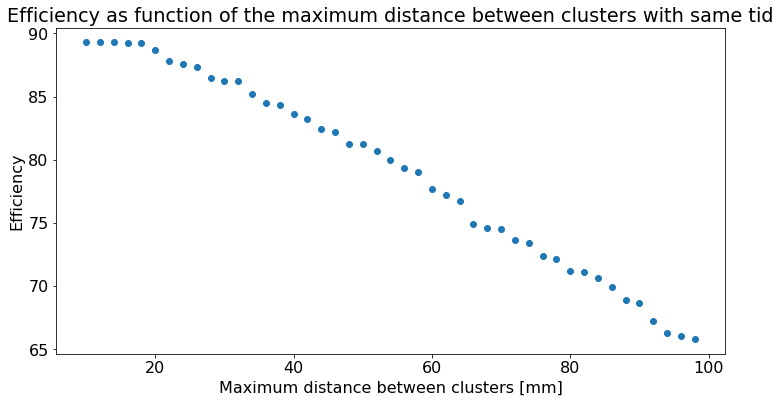

In [26]:
fig = plt.figure(figsize=(12,6))
plt.scatter(thresholds, efficiency)
plt.xlabel("Maximum distance between clusters [mm]")
plt.ylabel("Efficiency")
plt.title("Efficiency as function of the maximum distance between clusters with same tid")
#plt.savefig("efficiency_vs_max_distance_threshold_10-100_2_5000_frames_each_correct.png", dpi=300)
print(max(efficiency), thresholds[efficiency.index(max(efficiency))])

### Number of tids per cluster



1 tid: 15954
2 tids: 1709
3 tids: 212
4 tids: 35
>4 tids: 6


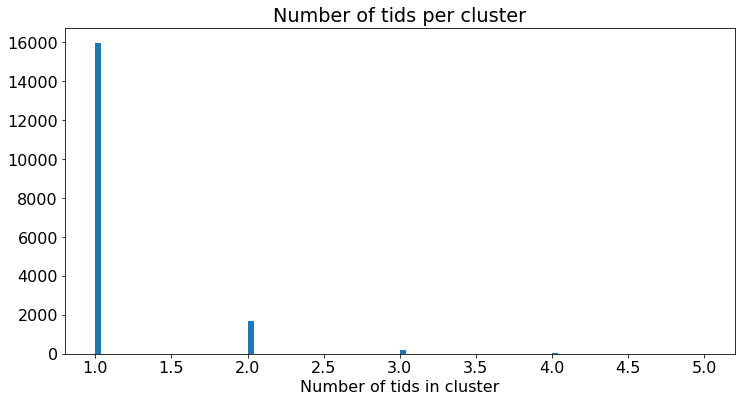

In [27]:
single_tid_counter = number_of_tids.count(1)
double_tid_counter = number_of_tids.count(2)
triple_tid_counter = number_of_tids.count(3)
quadruple_tid_counter = number_of_tids.count(4)
even_more_tids_counter = sum(i > 4 for i in number_of_tids)

print("1 tid:", single_tid_counter)
print("2 tids:", double_tid_counter)
print("3 tids:", triple_tid_counter)
print("4 tids:", quadruple_tid_counter)
print(">4 tids:", even_more_tids_counter)

fig = plt.figure(figsize=(12,6))
plt.hist(number_of_tids, bins = 100)
plt.xlabel("Number of tids in cluster")
plt.title("Number of tids per cluster")
#plt.savefig("efficiency_vs_max_distance_threshold_10-100_2_5000_frames_each_correct.png", dpi=300)
plt.show()

### Hits not included in any cluster

In [28]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "timetheniterativespatial")

Progress: 100 % of  1000  frameses
Not associated hits out of all hits:  0.0 %


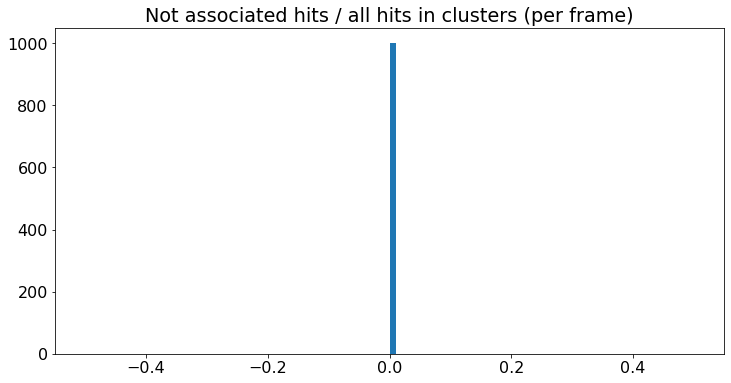

In [29]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

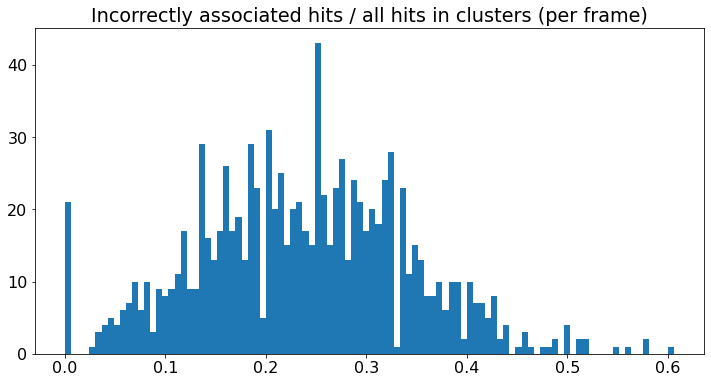

In [30]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

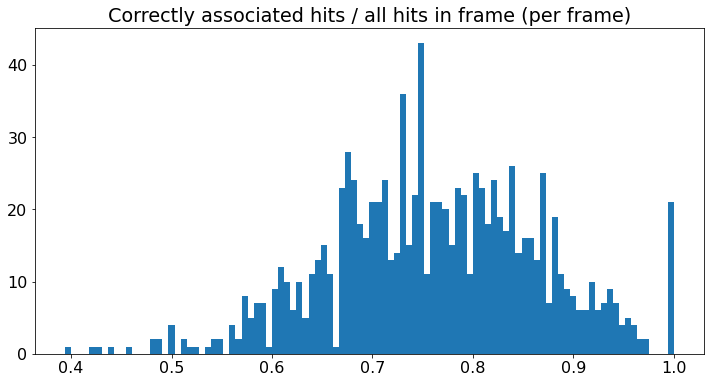

In [31]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

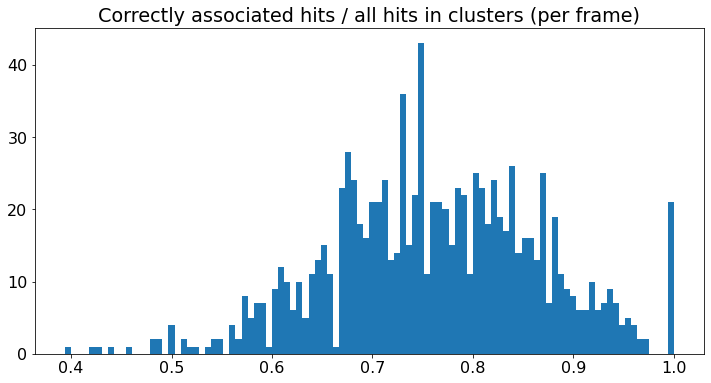

In [32]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

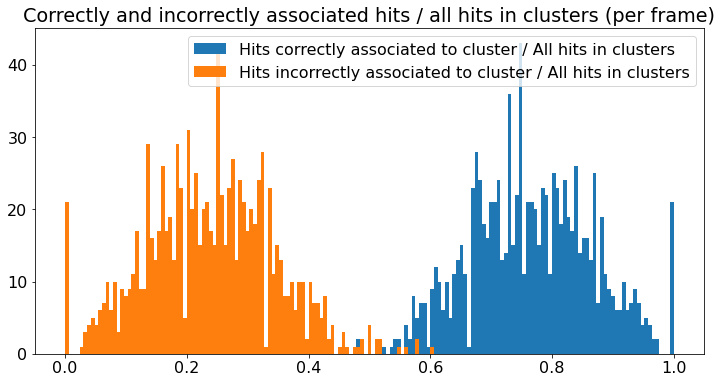

In [33]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()

## Maximum size of truth clusters

In [34]:
max_distances = clump.spatial_cluster.truth_cluster_size(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, mask_type = "big", number_of_frames = 1000, rec_type = None)

Progress: 100 % of  1000  frameses


In [35]:
print(max(max_distances))

921.4481645930543


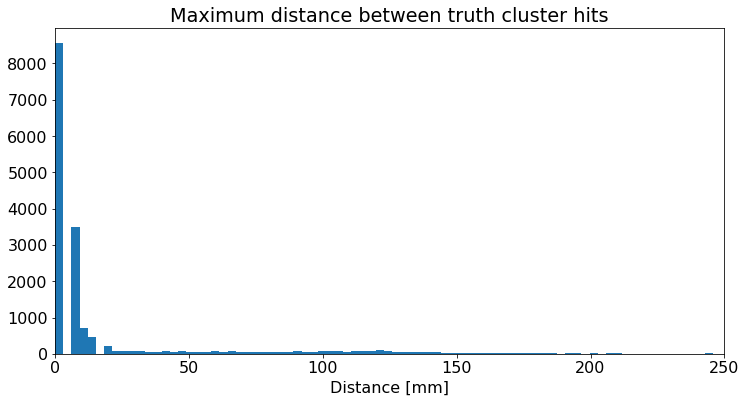

In [36]:
fig = plt.figure(figsize=(12,6))
plt.hist(max_distances, bins = 300)
plt.title("Maximum distance between truth cluster hits")
plt.xlabel("Distance [mm]")
plt.xlim(0,250)
#plt.savefig("truth_clusters_size_200k_frames.png", dpi = 300)
plt.show()

In [37]:
threshold = 20
counter_over_threshold = 0
for distance in max_distances:
    if distance > threshold:
        counter_over_threshold += 1
print(counter_over_threshold, "of", len(max_distances), "distances are over the threshold of", threshold, "mm")

3063 of 16369 distances are over the threshold of 20 mm


## Energy cut

In [38]:
clusters = clump.three_dim_cluster.iterative_masks_after_time_clustering(ttree_mu3e_big, ttree_mu3e_mc_big, 
                                                                         ttree_sensor_big, ttree_tiles_big, 
                                                                         mu3e_detector, frame_used, 
                                                                         time_threshold = time_threshold_used, 
                                                                         mask_type = "big", rec_type = None)


In [39]:
for cluster in clusters:
    for hit in cluster.hits:
        print(hit.edep)

0.19643351751915872
0.14814933943839215
1.416334502681211
0.3473508422458043
1.4652546332940586
1.1546598267358954
0.14581937248044718
0.8930811221787742
1.0754154852635818
1.1885545042675247
0.8727843470173929
0.5305858370582157
0.1528480314565272
0.44808991522934327
0.9611649922229262
0.253986679649079
0.8985128880262396
1.1779554310988547
1.1638547775582477
0.23919967386712818
1.4927101789474069
0.4826034294810743
0.9752048444519532
0.3091201806673232
0.9968429946134544
0.5732174560378231
0.15736704552022465
1.3337315620051802


## Truth Clusters

In [40]:
frac_corr_frame_tid, frac_corr_clusters_frame_tid, frac_uncorr_frame_tid, tot_corr_tid, total_hits_tid, number_of_tids = clump_plt.compare_to_tid(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, time_threshold = time_threshold_used, threshold_cluster_width=20, mask_type = "big", number_of_frames = 1000, rec_type = None, cluster_type = "truth")

Progress: 100 % of  1000  frameses
Number of analyzed frames:  1000 Number of correct counter fractions:  1000
Total number of hits = 31944 , Identified correctly + identified incorrectly = 31944
Identified correctly: 31944
Identified incorrectly: 0
Total #hits in frames/#hits in clusters =  1.0
Total number of clusters: 16369 , Hits: 31944
Number of clusters with hits that are far apart in time: 1736
Number of clusters where tid already exists: 0 , Hits: 0
Number of clusters where tid already exists, that are accounted for: 0
Correctly associated out of all hits:  100.0 %
Correctly associated out of all hits in clusters:  100.0 %
Incorrectly associated out of all hits:  0.0 %
Incorrectly associated out of all hits in clusters:  0.0 %


### Number of hits in truth clusters (per TID)

In [41]:
ratios, percentages, number_of_hits_per_tid, max_hits_per_tid = clump.spatial_cluster.hits_per_tid(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, mask_type = "big", number_of_frames = None, rec_type = None)

Progress: 100 % of  199841  framesmes
Mean number of hits per tid: 1.9397193742575047
Mean number of hits per tid without single hit clusters: 2.9803945030973003


In [42]:
print("Ratios of truth clusters with certain number of hits:")
for key in ratios.keys():
    print("#Hits:", key, "Ratio:", ratios[key], "Percentage:", percentages[key])

Ratios of truth clusters with certain number of hits:
#Hits: 1 Ratio: 0.5254887989298086 Percentage: 52.54887989298086
#Hits: 2 Ratio: 0.26924871966376823 Percentage: 26.924871966376823
#Hits: 3 Ratio: 0.09718731593606804 Percentage: 9.718731593606805
#Hits: 4 Ratio: 0.046994641555770746 Percentage: 4.699464155577075
#Hits: 5 Ratio: 0.025734321496670626 Percentage: 2.5734321496670627
#Hits: 6 Ratio: 0.014479903962303706 Percentage: 1.4479903962303706
#Hits: 7 Ratio: 0.008259790953288942 Percentage: 0.8259790953288941
#Hits: 8 Ratio: 0.004812491888708083 Percentage: 0.4812491888708083
#Hits: 9 Ratio: 0.0028835642763729297 Percentage: 0.28835642763729297
#Hits: 10 Ratio: 0.0017517270812327167 Percentage: 0.17517270812327165
#Hits: 11 Ratio: 0.0010881610078966547 Percentage: 0.10881610078966546
#Hits: 12 Ratio: 0.000701626750791163 Percentage: 0.07016267507911629
#Hits: 13 Ratio: 0.0004660873124419731 Percentage: 0.0466087312441973
#Hits: 14 Ratio: 0.00031634038474977286 Percentage: 0.031

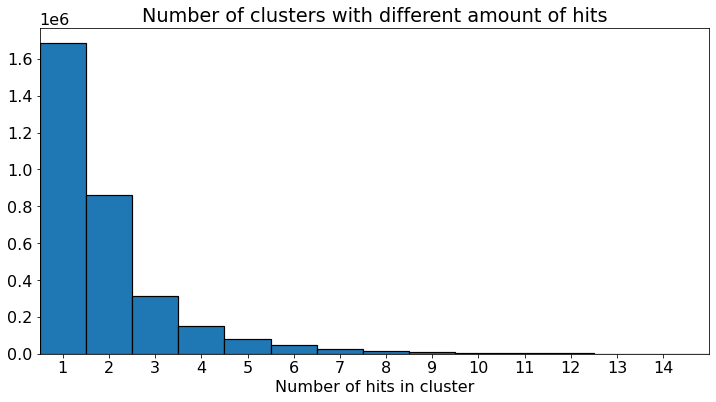

In [43]:
fig = plt.figure(figsize=(12,6))
bins = np.arange(max_hits_per_tid) - 0.5
plt.hist(number_of_hits_per_tid, bins, edgecolor='black', linewidth=1.2)
plt.title("Number of clusters with different amount of hits")
plt.xlabel("Number of hits in cluster")
plt.xlim(0.5,15)
plt.xticks(np.arange(1,15))
plt.savefig("number_of_hits_per_tid_200k_frames.png", dpi = 300)
plt.show()

### Cluster size vs number of TIDs

In [44]:
max_distances = clump.spatial_cluster.truth_cluster_size(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big,  mu3e_detector, mask_type = "big", number_of_frames = None, rec_type = None)

Progress: 100 % of  199841  framesmes


In [45]:
print(len(max_distances))
print(len(number_of_hits_per_tid))

for i in range(len(max_distances)):
    if max_distances[i] > 380 and max_distances[i] < 420:
        print(max_distances[i])

print(max(max_distances))
print(np.mean(max_distances))
print(max_distances[1:200])

3205408
3205408
1139.535804454453
21.70234761267067
[0.0, 0.0, 20.62535582898208, 12.819999999999993, 0.0, 6.500060129309255, 0.0, 7.058392385814576, 0.0, 245.31602660769258, 9.534621286245505, 6.409999999999968, 0.0, 143.89757402419653, 6.410000000000025, 21.277371584977907, 0.0, 106.31897010597034, 124.25338134682458, 6.500060129309252, 117.94601108943321, 0.0, 9.334306135000594, 58.03818904897968, 172.2407241137519, 0.0, 0.0, 14.373697564810328, 0.0, 0.0, 0.0, 0.0, 0.0, 6.409999999999968, 149.56253154304795, 0.0, 6.560000000000002, 6.409999999999968, 120.88247784403679, 0.0, 32.87593309420643, 6.410000000000025, 0.0, 0.0, 0.0, 0.0, 0.0, 6.785364472296962, 77.64256359552174, 6.410000000000082, 12.970000000000027, 0.0, 6.409999999999968, 82.66499658461899, 0.0, 9.534621286245486, 6.409999999999968, 0.0, 0.0, 0.0, 0.0, 6.560000000000002, 0.0, 0.0, 0.0, 189.8954475599034, 0.0, 14.637693500750336, 7.058392385814608, 25.79000000000002, 32.9071598747432, 6.410000000000025, 118.796663085858

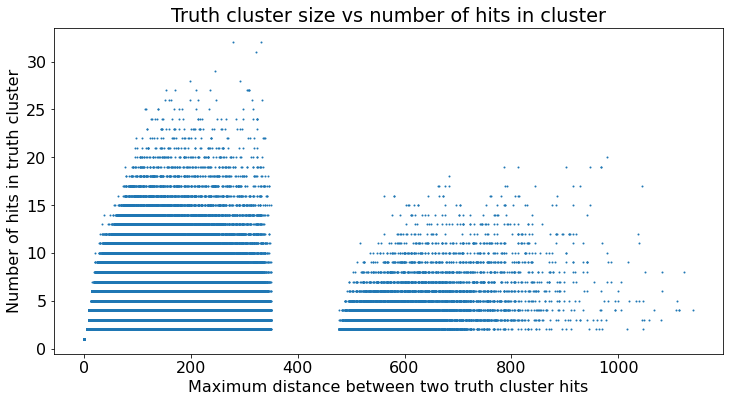

In [46]:
fig = plt.figure(figsize=(12,6))
plt.scatter(max_distances, number_of_hits_per_tid, s = 1)
plt.xlabel("Maximum distance between two truth cluster hits [mm]")
plt.ylabel("Number of hits in truth cluster")
plt.title("Truth cluster size vs number of hits in cluster")
plt.show()

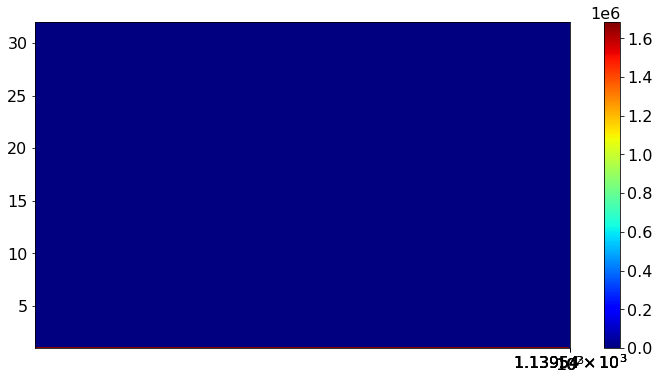

In [47]:
#fig = plt.figure(figsize=(12,6))
#plt.hist2d(max_distances, number_of_hits_per_tid, (500, 500), cmap=plt.cm.jet)
#plt.xscale('log')
#plt.colorbar()

In [49]:
from scipy.stats import gaussian_kde

# Calculate the point density
#xy = np.vstack([max_distances,number_of_hits_per_tid])
#z = gaussian_kde(xy)(xy)

#fig, ax = plt.subplots()
#ax.scatter(max_distances, number_of_hits_per_tid, c=z, s=100)
#plt.show()

<AxesSubplot:title={'center':'Truth cluster size vs number of hits in cluster'}, xlabel='Maximum distance between two truth cluster hits [mm]', ylabel='Number of hits in truth cluster'>

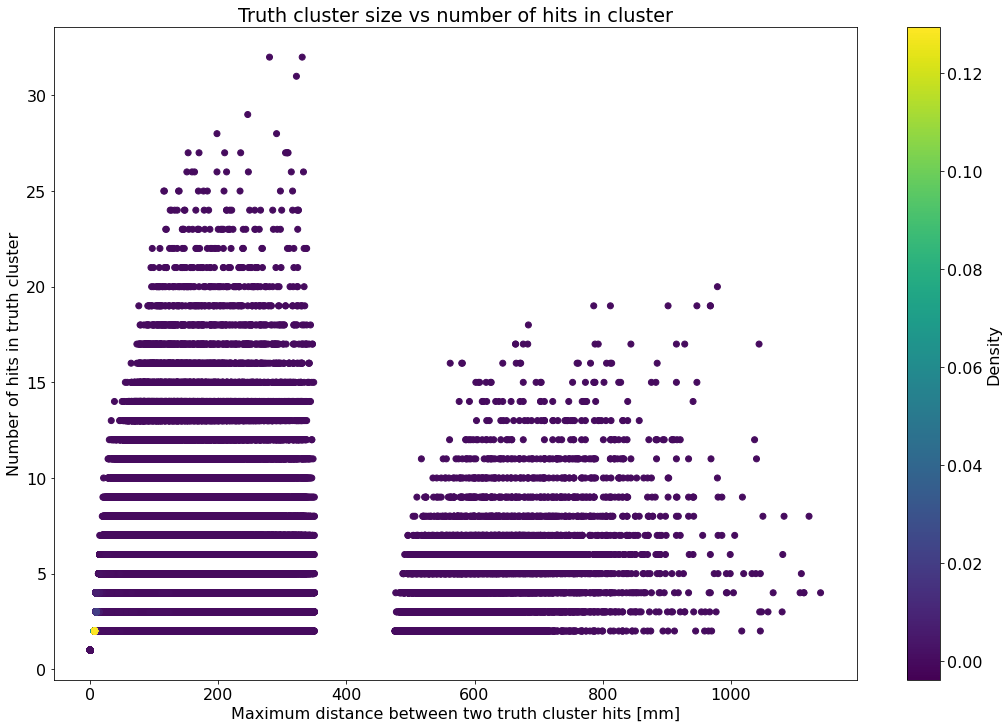

In [57]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(18,12))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    ax.set_xlabel("Maximum distance between two truth cluster hits [mm]")
    ax.set_ylabel("Number of hits in truth cluster")
    ax.set_title("Truth cluster size vs number of hits in cluster")

    return ax

tot_max_dist = math.ceil(np.max(max_distances))
tot_max_hits = np.max(number_of_hits_per_tid)
density_scatter(np.round(max_distances) , np.round(number_of_hits_per_tid), bins = [tot_max_dist, tot_max_hits] )

<AxesSubplot:title={'center':'Truth cluster size vs number of hits in cluster'}, xlabel='Maximum distance between two truth cluster hits [mm]', ylabel='Number of hits in truth cluster'>

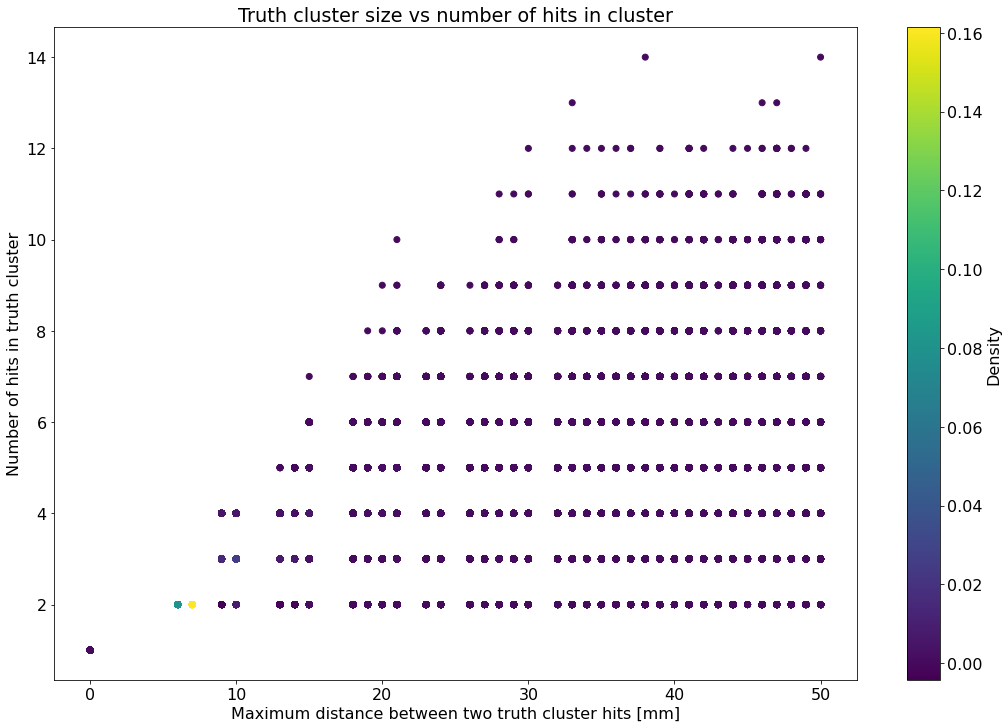

In [61]:
#cluster size limited and no single hit clusters
max_distances_lim = []
number_of_hits_per_tid_lim = []
for i in range(len(max_distances)):
    if max_distances[i] < 50 and number_of_hits_per_tid[i] > 0:
        max_distances_lim.append(max_distances[i])
        number_of_hits_per_tid_lim.append(number_of_hits_per_tid[i])
        
tot_max_dist_lim = math.ceil(np.max(max_distances_lim))
tot_max_hits_lim = np.max(number_of_hits_per_tid_lim)
density_scatter(np.round(max_distances_lim) , np.round(number_of_hits_per_tid_lim), bins = [tot_max_dist_lim, tot_max_hits_lim] )

In [ ]:
import math 
tot_max_dist = math.ceil(np.max(max_distances))
tot_max_hits = np.max(number_of_hits_per_tid)
heatmap = np.zeros((tot_max_hits+1,tot_max_dist+1))
for i in range(len(max_distances)):
    dist = int(np.round(max_distances[i]))
    hits = int(number_of_hits_per_tid[i])
    heatmap[hits][dist] += 1
    

In [ ]:
plt.imshow(heatmap, cmap='magma')

In [ ]:
print(heatmap[1:3])

In [ ]:
import math 
tot_max_dist = math.ceil(np.max(max_distances))
tot_max_hits = np.max(number_of_hits_per_tid)
heatmap = np.zeros((11,101))
for i in range(len(max_distances)):
    dist = int(np.round(max_distances[i]))
    hits = int(number_of_hits_per_tid[i])
    if dist < 100 and hits < 10:
        heatmap[hits][dist] += 1
        
row_sums = heatmap.sum(axis=1)
heatmap_norm = heatmap / row_sums[:, np.newaxis]

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.imshow(heatmap, cmap='magma')

In [ ]:
for i in range(11):
    for j in range(101):
        if heatmap[i][j] > 0:
            print(heatmap[i][j])